<a href="https://colab.research.google.com/github/sinchxn/contentbasedrecommender/blob/main/airbnb_content_based_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Airbnb Content-Based Recommendation System**
## **Introduction**
Team members: Roshni Govind (PES2UG19CS339), Sanjana Murthy (PES2UG19CS364), Sinchan Samajdar (PES2UG19CS390).

In this notebook, we will be attempting an implemention of a recommendation algorithm (content-based).

Here we will use listings data from Airbnb around Seattle area. The engine will learn from:
1. id: listings id for every room around Seattle
2. name: the title of room listings
3. description: details given by the host to describe their rooms



In [ ]:
# Importing the libraries
!pip3 install wordcloud
import pandas as pd
from IPython.display import Image, HTML
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
# Importing the dataset
listings = pd.read_csv('/content/listings.csv', usecols = ['id', 'name', 'description'],engine='python',error_bad_lines=False)
listings.head(10)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,id,name,description
0,241032,Stylish Queen Anne Apartment,Make your self at home in this charming one-be...
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...
5,5956968,Private unit in a 1920s mansion,We're renting out a small private unit of one ...
6,1909058,Queen Anne Private Bed and Bath,Enjoy a quiet stay in our comfortable 1915 Cra...
7,856550,Tiny Garden cabin on Queen Anne,"Our tiny cabin is private , very quiet and com..."
8,4948745,Urban Charm || Downtown || Views,"Nestled in the heart of the city, this space i..."
9,2493658,Airy + Bright Queen Anne Apartment,"Beautiful apartment in an extremely safe, quie..."


## Exploratory Data Analysis
Some words which are occured more frequently and considered more relevant. Figuring this out is done here with the help of a visual representation (wordcloud).

In [ ]:
listings['name'] = listings['name'].astype('str')
listings['description'] = listings['description'].astype('str')

In [ ]:
name_corpus = ' '.join(listings['name'])
description_corpus = ' '.join(listings['description'])

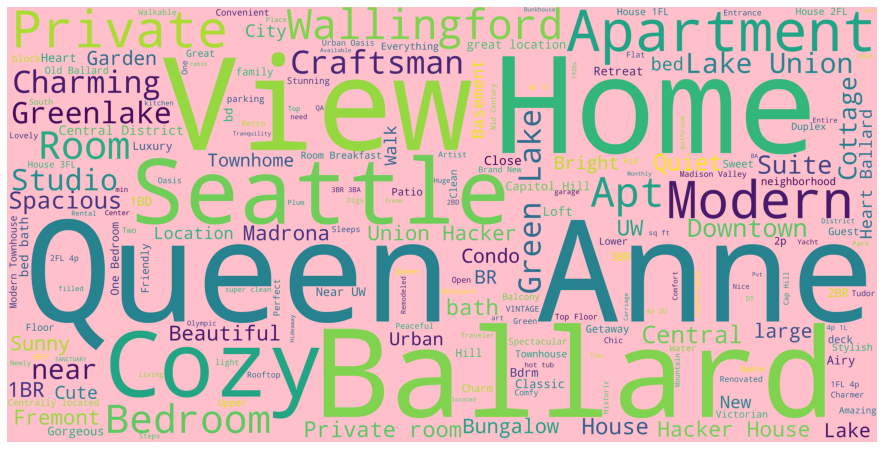

In [ ]:
name_wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'pink', height = 3000, width = 6000).generate(name_corpus)
plt.figure(figsize = (16,8))
plt.imshow(name_wordcloud)
plt.axis('off')
plt.show()

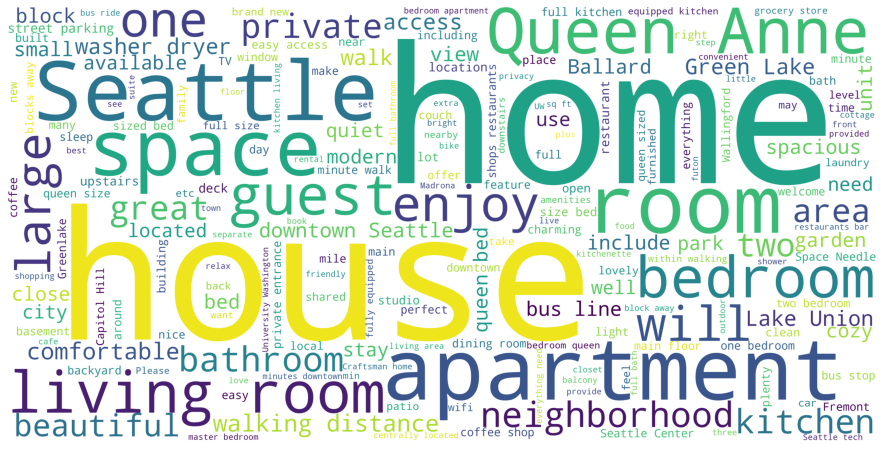

In [ ]:
description_wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white', height = 2000, width = 4000).generate(description_corpus)
plt.figure(figsize = (16,8))
plt.imshow(description_wordcloud)
plt.axis('off')
plt.show()

The most frequently words occurred in the name or title of listings are including: Queen, Seattle, Capitol Hill, View, Home, Cozy, etc.

For the description: house, home, apartment, living room, space. They are typical words for hosts when describing their listings.

creating a column containing a combination of name and description columns that is important for content-based recommendation system

In [ ]:
listings['content'] = listings[['name', 'description']].astype(str).apply(lambda x: ' // '.join(x), axis = 1)

In [ ]:
# Fillna
listings['content'].fillna('Null', inplace = True)

## Training the Recommender

## TF-IDF (Term Frequency - Inverse Document Frequency)
Creating a TF-IDF matrix of for each id or room. 
The “stop words” parameter tells the TF-IDF module to ignore common English words like 'the', ‘about’, etc.  
TF-IDF will parse through the descriptions, identify distinct phrases in each item's description, and then find similar contents based on those phrases. 

In [ ]:
tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2), min_df = 0, stop_words = 'english')
tfidf_matrix = tf.fit_transform(listings['content'])

## Cosine Similarity
Cosine Similarity calculates similarity by measuring the cosine angle between two vectors. Vectors are converted from contents by TF-IDF and this measurement will identify which contents are closest to each other.


In [ ]:
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

Iterating through each item's similar items and store the 100 most-similar

In [ ]:
results = {}
for idx, row in listings.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1]
    similar_items = [(cosine_similarities[idx][i], listings['id'][i]) for i in similar_indices]
    results[row['id']] = similar_items[1:]

## Making a prediction

In [ ]:
def item(id):
    name   = listings.loc[listings['id'] == id]['content'].tolist()[0].split(' // ')[0]
    desc   = ' \nDescription: ' + listings.loc[listings['id'] == id]['content'].tolist()[0].split(' // ')[1][0:165] + '...'
    prediction = name  + desc
    return prediction

def recommend(item_id, num):
    print('Recommending ' + str(num) + ' products similar to ' + item(item_id))
    print('---')
    recs = results[item_id][:num]
    for rec in recs:
        print('\nRecommended: ' + item(rec[1]) + '\n(score:' + str(rec[0]) + ')')

putting an id from listings data and number of recommendation to show as input

In [ ]:
recommend(item_id = 278830, num = 5)

Recommending 5 products similar to Charming craftsman 3 bdm house 
Description: Cozy family craftman house in beautiful neighborhood of Queen Anne, Seattle, Washinton. 3 bedrooms, can accomodate up to 6 people. 1,200 sq. feet space is your oasis...
---

Recommended: QUEEN ANNE VIEW ONE! - SEATTLE 
Description: Vintage 1927 4plex in perfect Queen Anne location. Elliott Bay views! Hardwoods, built-ins, natural light. Queen bed w/ new mattress. Charm & updated amenities: A/C,...
(score:0.08246584548608177)

Recommended: Location and View in Queen Anne 
Description: Great location with easy access to downtown Seattle, buses and walking to upper/lower Queen Anne plus South Lake Union.  Private deck with amazing views and open spa...
(score:0.08151016376348241)

Recommended: One private bedroom in a large Apt 
Description: This bedroom is yours and it comes with the shared common space. You have storage and the ability to walk or bus downtown within 10-15 minutes. The Seattle center an...
(s

In [ ]:
recommend(item_id = 3883392, num = 3)

Recommending 3 products similar to Open Plan 2bdr/1bath in Queen Anne 
Description: Spacious apt in popular Seattle neighborhood.  1 block to bus and easy access by car to groceries, gas, freeway, stadiums, cruise ships.  Well stocked, quiet and res...
---

Recommended: Spacious Apt in Queen Anne 
Description: Spacious basement one-bed/bath apartment available in a newly remodeled craftsman home in Seattle's Queen Anne neighborhood. Private entrance, fully furnished unit, ...
(score:0.05906663145209562)

Recommended: Large room in Ballard neighborhood  
Description: Great room available in Ballard neighborhood in Seattle.  Private room with Queen bed, very clean.  Apartment has kitchen, large bathroom, wifi, cable TV, use of lap...
(score:0.05345443545883249)

Recommended: Charming home on Queen Anne 
Description: Enjoy Seattle from the ideally located Queen Anne Hill.  Enjoy the quaintness and charm of Queen Anne while having easy access to all around the area. L Step into th...
(scor

In [ ]:
item(278830)

'Charming craftsman 3 bdm house \nDescription: Cozy family craftman house in beautiful neighborhood of Queen Anne, Seattle, Washinton. 3 bedrooms, can accomodate up to 6 people. 1,200 sq. feet space is your oasis...'